In [4]:
import os 
import google.generativeai as genai
import pathlib
import textwrap
from IPython.display import Markdown

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


In [11]:
with open ('sites.txt') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]
f.close()

In [11]:
# manual div class keywords
keywords = ["event", "content", "detail", "card", "views","location","time", "date", "notes", "evt"]

import datetime

# previous 10 years
years = [str(i) for i in range(2010, datetime.datetime.now().year)]

# all monnth in title case
old_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
index_of_month = old_months.index(datetime.datetime.now().strftime("%B"))
old_months = old_months[:index_of_month]

# list of sites needing selenium scraping
js_sites = {4:"s-lc-mc-evt",9:"spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe",1:"trumba.spud.5.iframe"}

### Main Functions


In [13]:
# Custom HTML Parsing as solution vs. LLM Text Extraction w/ HTML Filtering
import bs4
import requests
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

"""
1. Retrieve HTML from a site
1.1 Retrieve HTML from a site using Selenium
2. Extract event text from HTML
2.5 Preprocess Event Text
3. Store event text in a file
4. Convert to JSON or CSV via LLM
5. Store in a database

"""

# 1 - Retrieve HTML from a site
def get_html(site):
    response = requests.get(site)
    if response is None:
        print('Failed to retrieve html from site')
        return None
    return response.text

# 1.1 - Retrieve HTML from a site using Selenium
def get_html_selenium(site, id, site_dict):
    driver = webdriver.Chrome()
    driver.get(site)
    element = None
    target_element = site_dict[id]
    
    if ".iframe" in target_element:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, target_element))
        )
        driver.switch_to.frame(target_element)
        print("Found IFRAME")
        time.sleep(5)
    else:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CLASS_NAME, target_element))
        )

    html = driver.page_source
    driver.quit()
    return html

# --------------------------------------------------------------------------------------------

# 2 - Extract event text from HTML
def extract_event_text(soup):
    all_divs = soup.find_all('div')
    lowercase_all_divs_classes(all_divs)
    event_divs = filter_event_divs(all_divs)
    event_text = extract_text_from_event_divs(event_divs)
    return event_text

# 2.5 - Preprocess Event Text
def lowercase_all_divs_classes(divs):
    for div in divs:
        if div.has_attr('class'):
            div['class'] = [x.lower() for x in div['class']]

def filter_event_divs(all_divs):
    event_divs = []
    for div in all_divs:
        if div.get('class') is not None and any(keyword in div.get('class')[0] for keyword in keywords):
            event_divs.append(div)
    return event_divs

def extract_text_from_event_divs(event_divs):
    event_text = []
    for div in event_divs:
        text = div.get_text()
        text = [x for x in text.split('\n') if x != '']
        for line in text:
            if is_old_event(line):
                continue
            while '\n' in line:
                line = line.replace('\n', ' ')
            event_text.append(line + '\n')
    return event_text

def is_old_event(line):
    if any(year in line for year in years):
        return True
    elif any(month in line for month in old_months):
        return True
    return False

def remove_duplicates(event_text):
    return list(set(event_text))

# --------------------------------------------------------------------------------------------


# 3 - Store event text in a file
def write_event_text(event_text, filename):
    event_text = [x.encode('ascii', 'ignore').decode('ascii') for x in event_text]
    folder = "extracted_txt"
    file_path = folder + "/" + filename
    with open(file_path, 'w') as f:
        for event in event_text:
            if len(event) > 0 or event != ' ':
                f.write(event)
    f.close()
    return 0

# --------------------------------------------------------------------------------------------

# 4 - Convert to JSON or CSV via LLM
def convert_to_json(site_index):
    input_text = """ 
    Convert this text to JSON for events with this schema:
    Store the objects in a JSON array without duplicate entries.
    Event:
    - Title: The name of the event (String)
    - Start Time: (DateTime)
    - End Time: (DateTime)
    - Date: (Month, Day) of the event (DateTime)
    - Location: Where the event takes place (String)
    - Guest Speaker: The person or organization responsible for the event (String)
    Do not add '''JSON''' to the start or end of the file.
    """
    filename = f'site_{site_index}.txt'
    with open(f'extracted_txt/{filename}') as f:
        site_text = f.read()
    input_text += site_text

    model = genai.GenerativeModel('gemini-pro')
    response = model.generate_content(input_text)

    with open(f'event_jsons/site_{site_index}.json', 'w') as f:
        f.write(response.text)
    f.close()
    
    return 0

# --------------------------------------------------------------------------------------------

# 5 - Read JSON and store in a database
def read_json(site_index):
    with open(f'event_jsons/site_{site_index}.json') as f:
        event_json = f.read()
    f.close()
    return event_json

# X - Store as a CSV for now

# --------------------------------------------------------------------------------------------


def single_site(site):
    html = get_html_selenium(site)
    print(html)
    soup = bs4.BeautifulSoup(html, 'html.parser')
    event_text = extract_event_text(soup)
    write_event_text(event_text, 'site.txt')    
    print(len(event_text))
    print(event_text)
    return 0

def process_sites():
    for i, site in enumerate(lines):
        print(f"Processing site {site}")

        if i in js_sites:
            html = get_html_selenium(site)
        else:
            html = get_html(site)

        soup = bs4.BeautifulSoup(html, 'html.parser')
        event_text = extract_event_text(soup)
        write_event_text(event_text, f'site_{i}.txt')
        convert_to_json(i)

        print(f"Finished processing site {i}")
        # gemini pro free can only process 2 requests per minute
        time.sleep(30)
    return 0

In [5]:
process_sites()

Processing site https://scholarslab.lib.virginia.edu/events/
Finished processing site 0
Processing site https://www.virginia.edu/calendar
Virginia
Found IFRAME
Finished processing site 1
Processing site https://education.virginia.edu/events
Finished processing site 2
Processing site https://global.virginia.edu/events
Finished processing site 3
Processing site https://cal.lib.virginia.edu/calendar/events?cid=4299&t=m&d=0000-00-00&cal=4299&ct=69160,33395,66337,31015,30813,51597,58853,58854,58855,58856,70846,45972,31362,27888,30045,27381,57994,54907,26930,29624,56703,66253,66255,66338,46136,70848,33496,70427,27725,29618,63738,28898,33396,38996,50481,70849,51598,29985&inc=0
Finished processing site 4
Processing site https://engineering.virginia.edu/news-events/events
Finished processing site 5
Processing site https://commcal.mcintire.virginia.edu/
Finished processing site 6
Processing site https://www.arch.virginia.edu/events?search=&start=&end=&range=upcoming&events=&pageindex=1&pagesize=

0

### Json Playground

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
def convert_to_datetime(value):
    # remove .s in value
    new_value = value
    
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    
    while "." in new_value:
        new_value = new_value.replace('.', '')
        
    for fmt in ('%I:%M%p', '%I:%M %p', '%I%p', '%I %p'):
        try:
            return pd.to_datetime(new_value, format=fmt)
        except ValueError:
            pass
    return new_value

def edit_time(value):
    # if value is nan or a timestamp return value
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    
    times = str.split(value, ':')
    hour = int(times[0])
    if hour > 12:
        hour -= 12
        return str(hour) + ':' + times[1] + ' pm'
    if hour < 10:
        return value + ' pm'
    else:
        return value + ' am'

In [5]:
listdir_names_list = os.listdir('event_jsons')

In [61]:
all_events = []
event_dfs = []
nan_dfs = []
for file in os.listdir('event_jsons'):
    # TODO: Add the department of the event
    with open(f'event_jsons/{file}') as f:
        text = json.load(f)
    f.close()
    for event in text:
        all_events.append(event)
        
    df = pd.DataFrame(text)
    nan_df = df[df["Date"].isna()]
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df = df[df["Date"] > datetime.datetime.now()]
    df["Start Time"] = df["Start Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    df["End Time"] = df["End Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    
    df[df["Start Time"].isna()]["Start Time"] = df[df["Start Time"].isna()]["End Time"] - pd.Timedelta(hours=1)
    df[df["End Time"].isna()]["End Time"] = df[df["End Time"].isna()]["Start Time"] + pd.Timedelta(hours=1)
    
    df.drop_duplicates(subset=['Title'], inplace=True)
    event_dfs.append(df)
    nan_dfs.append(nan_df)

C:\Users\commo\AppData\Local\Temp\ipykernel_10792\476492133.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["Start Time"].isna()]["Start Time"] = df[df["Start Time"].isna()]["End Time"] - pd.Timedelta(hours=1)
C:\Users\commo\AppData\Local\Temp\ipykernel_10792\476492133.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["End Time"].isna()]["End Time"] = df[df["End Time"].isna()]["Start Time"] + pd.Timedelta(hours=1)
C:\Users\commo\AppData\Local\Temp\ipykernel_10792\476492133.py:20: Setting

In [60]:
all_events_df = pd.concat(event_dfs)
all_events_df.reset_index(drop=True, inplace=True)

nan_df = pd.concat(nan_dfs)
nan_df.reset_index(drop=True, inplace=True)

print(f'Total Events {nan_df.shape[0] + all_events_df.shape[0]}')

Total Events 63


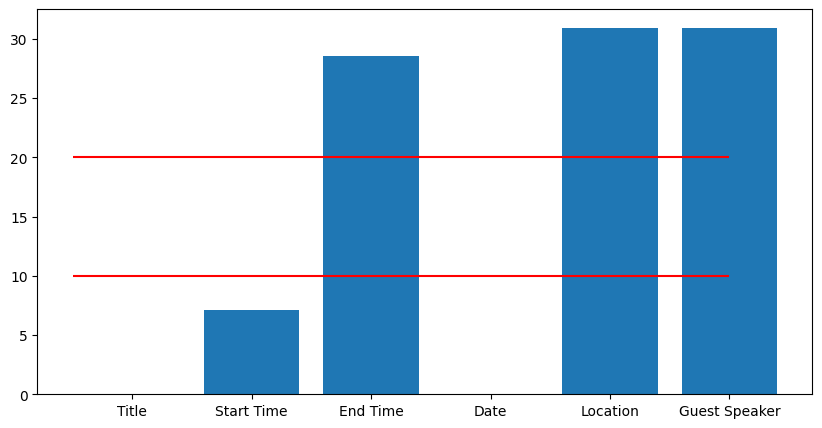

In [59]:
# sum isna
isna = all_events_df.isna().sum()
rows = all_events_df.shape[0]
isna_percent = isna / rows * 100
plt.figure(figsize=(10, 5))
plt.bar(isna_percent.index, isna_percent)
plt.hlines(20, -.5, 5, colors='r')
plt.hlines(10, -.5, 5, colors='r')

In [12]:
test_transformations = all_events_df.copy()
test_transformations["Date"] = pd.to_datetime(test_transformations["Date"], errors='coerce')
# remove date_time that are before today
test_transformations = test_transformations[test_transformations["Date"] > datetime.datetime.now()]
test_transformations.sort_values(by='Date', inplace=True, ascending=True)

In [32]:
test_transformations["Start Time"] = test_transformations["Start Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
test_transformations["End Time"] = test_transformations["End Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)

In [33]:
test_transformations

,Title,Start Time,End Time,Date,Location,Guest Speaker
54,Miraculous Objects: Relics and Buddha Images i...,1900-01-01 12:00:00,NaT,2024-04-11,New Cabell Hall,Professor Max Deeg (Cardiff University)
106,Bias in Healthcare,1900-01-01 10:00:00,1900-01-01 11:00:00,2024-04-11,None,"Kimberley R. Barker, MLIS"
109,New Opportunities to Accelerate Gender Equity ...,1900-01-01 12:00:00,1900-01-01 13:00:00,2024-04-11,None,"Julie K. Silver, MD"
110,COWIMS Event: Strategies to Increase Your Publ...,1900-01-01 10:00:00,1900-01-01 11:30:00,2024-04-11,None,"Julie K. Silver, MD"
55,National defense strategy: Asking what you can...,1900-01-01 14:00:00,NaT,2024-04-11,The Miller Center,members of the Commission on the National Defe...
108,Strategies to Increase Your Publishing Success...,1900-01-01 10:00:00,1900-01-01 11:30:00,2024-04-11,None,"Julie K. Silver, MD"
24,Applied Micro Workshop: Marcus Casey,1900-01-01 15:30:00,1900-01-01 17:00:00,2024-04-11,"Monroe Hall, Room 120",Marcus Casey
14,Virtual Info Session - UVA in Valencia Interme...,1900-01-01 17:06:00,1900-01-01 18:00:00,2024-04-11,None,None
107,Strategies for crafting a successful K99/R00 P...,1900-01-01 11:00:00,1900-01-01 15:30:00,2024-04-11,None,None
12,Social Entrepreneurs and Ventures in Food Justice,1900-01-01 16:06:00,NaT,2024-04-11,"Darden - North Grounds, CLA 140",Clara Camber and Eric Walter


### LLM Playground

In [ ]:
to_markdown(response.text)


> ```JSON
> [
>   {
>     "Title": "Graduate Writing Cafe",
>     "Start Time": "12:00 PM",
>     "End Time": "3:00 PM",
>     "Date": "09 April",
>     "Location": "Holloway Hall, Bavaro",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "Introduction to Graduate Study at the UVA School of Education and Human Development",
>     "Start Time": "4:00 PM",
>     "End Time": "5:00 PM",
>     "Date": "11 April",
>     "Location": "Virtual",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "UVA Communication Science and Disorders Accreditation Public Meeting",
>     "Start Time": "4:30 PM",
>     "End Time": "6:00 PM",
>     "Date": "17 April",
>     "Location": "Room 318A, Bavaro Hall",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "Wheelchair Takeover: Paralympic Pick-up",
>     "Start Time": "3:00 PM",
>     "End Time": "6:00 PM",
>     "Date": "19 April",
>     "Location": "Memorial Gym Outdoor Courts",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "EHD Black Alumni Weekend Events: Honoring the Past, Advancing in the Future",
>     "Start Time": "3:30 PM",
>     "End Time": "5:30 PM",
>     "Date": "19 April",
>     "Location": "Holloway Hall, Bavaro",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "M.Ed. in Administration & Supervision Information Session",
>     "Start Time": "4:00 PM",
>     "End Time": "5:00 PM",
>     "Date": "22 April",
>     "Location": "Virtual",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "M.Ed. in Administration & Supervision Information Session",
>     "Start Time": "6:00 PM",
>     "End Time": "7:00 PM",
>     "Date": "23 April",
>     "Location": "Virtual",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "How to Become a Teacher Information Session April 2024",
>     "Start Time": "7:00 PM",
>     "End Time": "8:00 PM",
>     "Date": "23 April",
>     "Location": "Virtual",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "EHD Yoga",
>     "Start Time": "9:00 AM",
>     "End Time": "10:00 AM",
>     "Date": "29 April",
>     "Location": "Holloway/Bavaro atrium",
>     "Guest Speaker": null
>   },
>   {
>     "Title": "Ice Cream Social",
>     "Start Time": "12:00 PM",
>     "End Time": "2:00 PM",
>     "Date": "30 April",
>     "Location": "Bavaro Atrium/Courtyard",
>     "Guest Speaker": null
>   }
> ]
> ```

### Test Functions

In [18]:
import unittest

class TestEventExtraction(unittest.TestCase):
    def setUp(self):
        self.html = """
        <html>
            <body>
                <div class="event">Event 1</div>
                <div class="content">Content 1</div>
                <div class="detail">Detail 1</div>
                <div class="card">Card
                <div class="views">Views 1</div>
                <div class="location">Location 1</div>
        </html>
        """
        self.soup = bs4.BeautifulSoup(self.html, 'html.parser')
        self.all_divs = self.soup.find_all('div')
    
    def test_lowercase_all_divs_classes(self):
        lowercase_all_divs_classes(self.all_divs)
        for div in self.all_divs:
            if div.has_attr('class'):
                self.assertTrue(all(x.islower() for x in div['class']))
    
    def test_filter_event_divs(self):
        event_divs = filter_event_divs(self.all_divs)
        self.assertTrue(all(any(keyword in div.get('class')[0] for keyword in keywords) for div in event_divs))
    
    def test_is_old_event(self):
        old_event = "Event from 2010"
        self.assertTrue(is_old_event(old_event))
                
    def test_extract_html(self):
        site = 'https://www.google.com'
        html = get_html(site)
        self.assertIsNotNone(html)
        
    def test_extract_selenium_html(self):
        site = 'https://www.virginia.edu/calendar'
        id = 1
        site_dict = {4:"s-lc-mc-evt",9:"spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe",1:"trumba.spud.5.iframe"}
        html = get_html_selenium(site, id, site_dict)
        self.assertIsNotNone(html)
                
    
    
unittest.main(argv=[''], exit=False)

.

Found IFRAME


....
----------------------------------------------------------------------
Ran 5 tests in 16.034s

OK


In [ ]:
def test_parsings(sites):
    for id, site in enumerate(sites):
        if id == 1 or id == 4 or id == 9:
            print(site)
            html = get_html_selenium(site)
        else:
            html = get_html(site)
        if html is not None:
            soup = bs4.BeautifulSoup(html, 'html.parser')
            event_text = extract_event_text(soup)
            print(len(event_text), site)
    return 0 

In [ ]:
test_parsings(lines)

84 https://scholarslab.lib.virginia.edu/events/
https://www.virginia.edu/calendar
Virginia
Found IFRAME
33 https://www.virginia.edu/calendar
595 https://education.virginia.edu/events
88 https://global.virginia.edu/events
https://cal.lib.virginia.edu/calendar/events?cid=4299&t=m&d=0000-00-00&cal=4299&ct=69160,33395,66337,31015,30813,51597,58853,58854,58855,58856,70846,45972,31362,27888,30045,27381,57994,54907,26930,29624,56703,66253,66255,66338,46136,70848,33496,70427,27725,29618,63738,28898,33396,38996,50481,70849,51598,29985&inc=0
57 https://cal.lib.virginia.edu/calendar/events?cid=4299&t=m&d=0000-00-00&cal=4299&ct=69160,33395,66337,31015,30813,51597,58853,58854,58855,58856,70846,45972,31362,27888,30045,27381,57994,54907,26930,29624,56703,66253,66255,66338,46136,70848,33496,70427,27725,29618,63738,28898,33396,38996,50481,70849,51598,29985&inc=0
1152 https://engineering.virginia.edu/news-events/events
24 https://commcal.mcintire.virginia.edu/
22 https://www.arch.virginia.edu/events?sea

0